# Importing Libraries #

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers

import matplotlib.pyplot as plt
import seaborn as sns

# Loading the Dataset #

Loading Dataset from keras

In [2]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

Dataset: Fashion MNIST  
This is a dataset of 60,000 28x28 grayscale images of 10 fashion categories, along with a test set of 10,000 images. This dataset can be used as a drop-in replacement for MNIST.

The Classes are:

| Label | Description |
| --- | --- |
| 0 | T-shirt/top |
| 1 | Trouser |
| 2 | Pullover |
| 3 | Dress |
| 4 | Coat |
| 5 | Sandal |
| 6 | Shirt |
| 7 | Sneaker |
| 8 | Bag |
| 9 | Ankle boot |

Creating Validation Data  
Validation Data will be last 10000 images from the train set  
The new train set will then be the first 50000 images  

In [3]:
X_val = X_train[-10000:]
y_val = y_train[-10000:]

X_train = X_train[:-10000]
y_train = y_train[:-10000]

Class Labels

In [4]:
class_names = {
    0: 'T-shirt/top', 1: 'Trouser', 2: 'Pullover', 3: 'Dress', 4: 'Coat',
    5: 'Sandal', 6: 'Shirt', 7: 'Sneaker', 8: 'Bag', 9: 'Ankle boot'
}

fmnist_numClasses = len(class_names)

## Data Exploration ##

Shape of the Arrays

In [5]:
print(f'Shape of X_train: {X_train.shape}')
print(f'Shape of y_train: {y_train.shape}')
print()

print(f'Shape of X_val: {X_val.shape}')
print(f'Shape of y_val: {y_val.shape}')
print()

print(f'Shape of X_test: {X_test.shape}')
print(f'Shape of y_test: {y_test.shape}')
print()

Shape of X_train: (50000, 28, 28)
Shape of y_train: (50000,)

Shape of X_val: (10000, 28, 28)
Shape of y_val: (10000,)

Shape of X_test: (10000, 28, 28)
Shape of y_test: (10000,)



Changing Data to Tensorflow Dataset

In [6]:
trainDS = tf.data.Dataset.from_tensor_slices((X_train, y_train))
valDS = tf.data.Dataset.from_tensor_slices((X_val, y_val))
testDS = tf.data.Dataset.from_tensor_slices((X_test, y_test))

Shuffling and batching the datasets

In [7]:
BATCH_SIZE = 64
SHUFFLE_BUFFER_SIZE = 1000

trainDS = trainDS.shuffle(SHUFFLE_BUFFER_SIZE, seed=42).batch(BATCH_SIZE)
valDS = valDS.batch(BATCH_SIZE)
testDS = testDS.batch(BATCH_SIZE)

Showing first 10 images from the training set

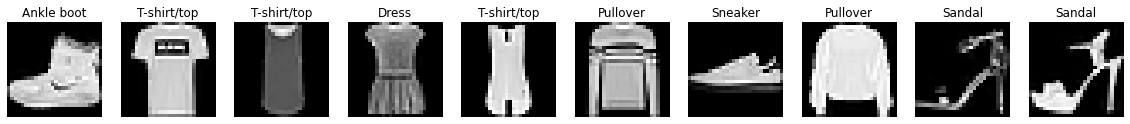

In [8]:
plt.figure(figsize=(20, 20))

for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.imshow(X_train[i], cmap='gray')
    plt.title(class_names[y_train[i]])
    plt.axis('off')

plt.show()

Applying Uniform Manifold Approximation & Projection

In [10]:
import umap

reducer = umap.UMAP()
embedding = reducer.fit_transform(X_train.reshape(X_train.shape[0], X_train.shape[1] * X_train.shape[2]))
print(f'Shape of embedded images: {embedding.shape}')

Shape of embedded images: (50000, 2)


From the UMAP plot, it can be seen that the dataset is not very complex and could somewhat be visualised on a 2 dimensional plane

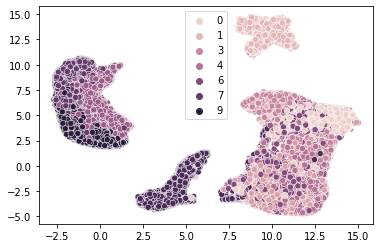

In [12]:
plt.figure(figsize=(20, 10))
sns.scatterplot(x=embedding[:, 0], y=embedding[:, 1], hue=y_train)
plt.show()

# Data Augmentation Layers #

In [9]:
input = layers.Input((28, 28, 1))
x = layers.RandomFlip('horizontal', seed=42)(input)
x = layers.RandomRotation(0.25, seed=42)(x)
output = layers.RandomZoom(0.2, 0.2, seed=42)(x)

dataAugmentation = keras.Model(inputs=input, outputs=output)

Augmenting Train Set

In [10]:
trainDS = trainDS.map(lambda x, y: (dataAugmentation(x), y))

# Model Building #

## Model 1 ##  
Simple and Shallow Model

<img src='Images/Model1_Arch.png' width='300' height='500' style='display:block; margin: auto'/>
<p style='text-align: center'>
    <b>Model 1 Architecture</b>
</p>

In [11]:
input = layers.Input((28, 28, 1))
x = layers.Rescaling(1/255)(input)

x = layers.Conv2D(16, 3, padding='same', activation='relu')(x)
x = layers.Conv2D(32, 3, padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPool2D()(x)

x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
x = layers.Conv2D(128, 3, padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPool2D()(x)

x = layers.Dropout(0.2)(x)
x = layers.Flatten()(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.BatchNormalization()(x)

output = layers.Dense(fmnist_numClasses, activation='softmax')(x)

model1 = keras.Model(inputs=input, outputs=output, name='Model_1')

In [12]:
model1.summary()

Model: "Model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 rescaling (Rescaling)       (None, 28, 28, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 16)        160       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        4640      
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                         

## Model 2 ##

<img src='Images/Model2_Arch.png' width='300' height='500' style='display:block; margin: auto'/>
<p style='text-align: center'>
    <b>Model 2 Architecture</b>
</p>

In [13]:
input = layers.Input((28, 28, 1))
x = layers.Rescaling(1/255)(input)

x = layers.Conv2D(16, 3, padding='same', activation='relu')(x)
x = layers.Conv2D(32, 3, padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPool2D()(x)

x = layers.Dense(64, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.BatchNormalization()(x)

x = layers.Conv2D(256, 3, padding='same', activation='relu')(x)
x = layers.Conv2D(128, 3, padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPool2D()(x)

x = layers.Flatten()(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.BatchNormalization()(x)
output = layers.Dense(fmnist_numClasses, activation='softmax')(x)

model2 = keras.Model(inputs=input, outputs=output, name='Model_2')

In [14]:
model2.summary()

Model: "Model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 28, 28, 1)         0         
                                                                 
 conv2d_4 (Conv2D)           (None, 28, 28, 16)        160       
                                                                 
 conv2d_5 (Conv2D)           (None, 28, 28, 32)        4640      
                                                                 
 batch_normalization_3 (Batc  (None, 28, 28, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                       

## Model 3 ##

<img src='Images/Block.png' width='300' height='500' style='display:block; margin: auto'/>
<p style='text-align: center'>
    <b>Block Architecture</b>
</p>

Note that the add between block 2 and block 3, the output of block 1 was first Max Pooled then it was then it was added with the output of model 2

<img src='Images/Model3_Arch.png' width='300' height='500' style='display:block; margin: auto'/>
<p style='text-align: center'>
    <b>Model 3 Architecture</b>
</p>

In [93]:
input = layers.Input((28, 28, 1))
x = layers.Rescaling(1/255)(input)

x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
block0_output = layers.BatchNormalization()(x)

# Block 1
x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
x = layers.Conv2D(16, 3, padding='same', activation='relu')(x)
x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
block1_output = layers.BatchNormalization()(x)
x = layers.Concatenate()([block1_output, block0_output])
block1_output = layers.MaxPool2D()(x)

x = layers.Dense(64, activation='relu')(block1_output)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(16, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(64, activation='relu')(x)
x1 = layers.BatchNormalization()(x)

# Block 2
x = layers.Conv2D(64, 3, padding='same', activation='relu')(x1)
x = layers.Conv2D(16, 3, padding='same', activation='relu')(x)
x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
block2_output = layers.BatchNormalization()(x)
x = layers.Concatenate()([block2_output, block1_output])
block2_output = layers.MaxPool2D()(x)

x = layers.Dense(64, activation='relu')(block2_output)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(16, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(64, activation='relu')(x)
x2 = layers.BatchNormalization()(x)
x1 = layers.MaxPool2D()(x1)
x = layers.Add()([x1, x2])

# Block 3
x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
x = layers.Conv2D(16, 3, padding='same', activation='relu')(x)
x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
block3_output = layers.BatchNormalization()(x)
x = layers.Concatenate()([block3_output, block2_output])
x = layers.MaxPool2D()(x)

x = layers.Dense(64, activation='relu')(block3_output)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(16, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(64, activation='relu')(x)
x3 = layers.BatchNormalization()(x)
x = layers.Add()([x2, x3])

# Block 4
x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
x = layers.Conv2D(16, 3, padding='same', activation='relu')(x)
x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
block4_output = layers.BatchNormalization()(x)
x = layers.Concatenate()([block4_output, block2_output])
x = layers.MaxPool2D()(x)

x = layers.Dense(64, activation='relu')(block3_output)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(16, activation='relu')(block3_output)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(64, activation='relu')(x)
x4 = layers.BatchNormalization()(x)
x = layers.Add()([x3, x4])

x = layers.Dropout(0.2)(x)
x = layers.Flatten()(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.BatchNormalization()(x)
output = layers.Dense(fmnist_numClasses, activation='softmax')(x)

model3 = keras.Model(inputs=input, outputs=output, name='Model_3')

In [94]:
model3.summary()

Model: "Model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 rescaling_6 (Rescaling)        (None, 28, 28, 1)    0           ['input_7[0][0]']                
                                                                                                  
 conv2d_57 (Conv2D)             (None, 28, 28, 64)   640         ['rescaling_6[0][0]']            
                                                                                                  
 conv2d_58 (Conv2D)             (None, 28, 28, 64)   36928       ['conv2d_57[0][0]']              
                                                                                            

## Model 4 ##

<img src='Images/Model4_Arch.png' width='300' height='500' style='display:block; margin: auto'/>
<p style='text-align: center'>
    <b>Model 4 Architecture</b>
</p>

In [24]:
input = layers.Input((28, 28, 1))
x = layers.Rescaling(1/255)(input)

x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
x = layers.Conv2D(32, 1, padding='same', activation='relu')(x)
x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)

x = layers.Conv2D(128, 3, padding='same', activation='relu')(x)
x = layers.Conv2D(64, 1, padding='same', activation='relu')(x)
x = layers.Conv2D(128, 3, padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPool2D()(x)

x = layers.Dense(32, activation='relu')(x)
x = layers.BatchNormalization()(x)

x = layers.Conv2D(128, 3, padding='same', activation='relu')(x)
x = layers.Conv2D(64, 1, padding='same', activation='relu')(x)
x = layers.Conv2D(128, 3, padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)

x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
x = layers.Conv2D(32, 1, padding='same', activation='relu')(x)
x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)

x = layers.Dropout(0.2)(x)
x = layers.Flatten()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.BatchNormalization()(x)

output = layers.Dense(fmnist_numClasses, activation='softmax')(x)

model4 = keras.Model(inputs=input, outputs=output, name='Model_4')

In [25]:
model4.summary()

Model: "Model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 rescaling_7 (Rescaling)     (None, 28, 28, 1)         0         
                                                                 
 conv2d_72 (Conv2D)          (None, 28, 28, 64)        640       
                                                                 
 conv2d_73 (Conv2D)          (None, 28, 28, 32)        2080      
                                                                 
 conv2d_74 (Conv2D)          (None, 28, 28, 64)        18496     
                                                                 
 batch_normalization_52 (Bat  (None, 28, 28, 64)       256       
 chNormalization)                                                
                                                           

# Model Testing #

## Function for plotting accuracy and loss ##

In [11]:
def plotFallOffGraph(history, accuracy='accuracy', val_accuracy='val_accuracy', loss='loss', val_loss='val_loss'):
    acc = history.history[accuracy]
    val_acc = history.history[val_accuracy]

    loss = history.history[loss]
    val_loss = history.history[val_loss]

    epochs_range = range(len(history.epoch))

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

## Model 1 ##

In [20]:
model1.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

In [21]:
history1 = model1.fit(trainDS, epochs=15, validation_data=valDS)

Epoch 1/15
782/782 [==============================] - 43s 52ms/step - loss: 0.8309 - accuracy: 0.7039 - val_loss: 0.7384 - val_accuracy: 0.7226
Epoch 2/15
782/782 [==============================] - 39s 50ms/step - loss: 0.5849 - accuracy: 0.7904 - val_loss: 0.9524 - val_accuracy: 0.6523
Epoch 3/15
782/782 [==============================] - 40s 51ms/step - loss: 0.5117 - accuracy: 0.8152 - val_loss: 0.5279 - val_accuracy: 0.7976
Epoch 4/15
782/782 [==============================] - 39s 50ms/step - loss: 0.4703 - accuracy: 0.8315 - val_loss: 0.5415 - val_accuracy: 0.8054
Epoch 5/15
782/782 [==============================] - 40s 51ms/step - loss: 0.4355 - accuracy: 0.8423 - val_loss: 0.5258 - val_accuracy: 0.8025
Epoch 6/15
782/782 [==============================] - 40s 51ms/step - loss: 0.4177 - accuracy: 0.8493 - val_loss: 0.4062 - val_accuracy: 0.8466
Epoch 7/15
782/782 [==============================] - 39s 50ms/step - loss: 0.3990 - accuracy: 0.8544 - val_loss: 0.4293 - val_accuracy:

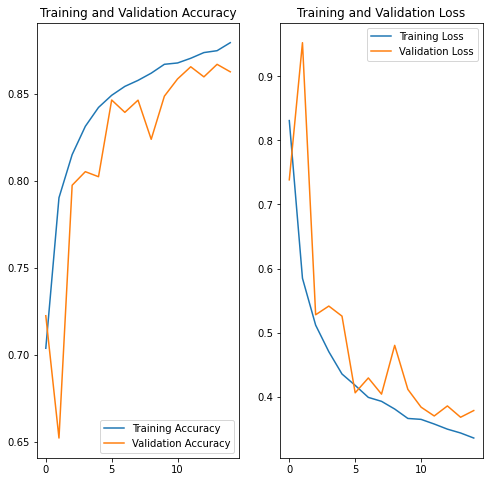

In [22]:
plotFallOffGraph(history1)

In [23]:
print(f'The highest validation accuracy obtained: {max(history1.history["val_accuracy"])}')
print(f'The lowest loss obtained: {min(history1.history["val_loss"])}')

The highest validation obtained: 0.8671000003814697
The lowest loss obtained: 0.36800962686538696


Saving Model 1

In [24]:
model1.save('./Models/Model1/')

INFO:tensorflow:Assets written to: ./Models/Model1/assets


INFO:tensorflow:Assets written to: ./Models/Model1/assets


In [25]:
tf.keras.backend.clear_session()

## Model 2 ##

In [26]:
model2.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

In [27]:
history2 = model2.fit(trainDS, epochs=15, validation_data=valDS)

Epoch 1/15
782/782 [==============================] - 56s 70ms/step - loss: 0.7955 - accuracy: 0.7225 - val_loss: 3.0225 - val_accuracy: 0.3937
Epoch 2/15
782/782 [==============================] - 53s 68ms/step - loss: 0.5627 - accuracy: 0.7986 - val_loss: 0.7839 - val_accuracy: 0.7205
Epoch 3/15
782/782 [==============================] - 54s 70ms/step - loss: 0.4967 - accuracy: 0.8199 - val_loss: 0.7551 - val_accuracy: 0.7269
Epoch 4/15
782/782 [==============================] - 56s 71ms/step - loss: 0.4556 - accuracy: 0.8362 - val_loss: 0.5185 - val_accuracy: 0.8036
Epoch 5/15
782/782 [==============================] - 55s 71ms/step - loss: 0.4302 - accuracy: 0.8457 - val_loss: 0.4988 - val_accuracy: 0.8181
Epoch 6/15
782/782 [==============================] - 56s 71ms/step - loss: 0.4023 - accuracy: 0.8559 - val_loss: 0.4291 - val_accuracy: 0.8381
Epoch 7/15
782/782 [==============================] - 55s 71ms/step - loss: 0.3935 - accuracy: 0.8590 - val_loss: 0.5154 - val_accuracy:

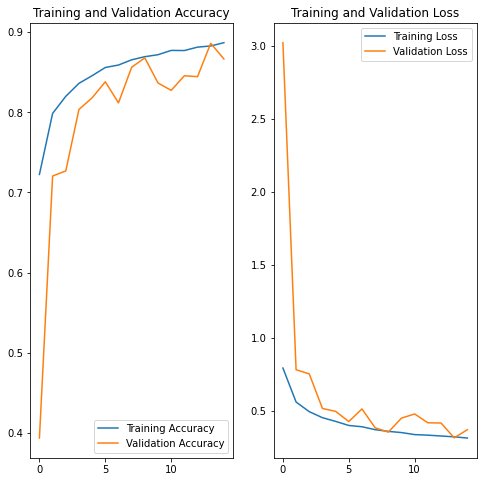

In [28]:
plotFallOffGraph(history2)

In [29]:
print(f'The highest validation accuracy obtained: {max(history2.history["val_accuracy"])}')
print(f'The lowest loss obtained: {min(history2.history["val_loss"])}')

The highest validation obtained: 0.8860999941825867
The lowest loss obtained: 0.3175593912601471


Saving Model 2

In [30]:
model2.save('./Models/Model2/')

INFO:tensorflow:Assets written to: ./Models/Model2/assets


INFO:tensorflow:Assets written to: ./Models/Model2/assets


In [97]:
tf.keras.backend.clear_session()

## Model 3 ##

In [98]:
model3.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

In [99]:
history3 = model3.fit(trainDS, epochs=15, validation_data=valDS)

Epoch 1/15
782/782 [==============================] - 72s 88ms/step - loss: 0.9051 - accuracy: 0.6661 - val_loss: 0.6639 - val_accuracy: 0.7538
Epoch 2/15
782/782 [==============================] - 70s 89ms/step - loss: 0.6882 - accuracy: 0.7455 - val_loss: 0.7086 - val_accuracy: 0.7364
Epoch 3/15
782/782 [==============================] - 70s 89ms/step - loss: 0.6124 - accuracy: 0.7735 - val_loss: 0.7785 - val_accuracy: 0.7069
Epoch 4/15
782/782 [==============================] - 70s 89ms/step - loss: 0.5691 - accuracy: 0.7921 - val_loss: 0.8014 - val_accuracy: 0.6929
Epoch 5/15
782/782 [==============================] - 70s 90ms/step - loss: 0.5381 - accuracy: 0.8022 - val_loss: 0.5201 - val_accuracy: 0.8028
Epoch 6/15
782/782 [==============================] - 70s 89ms/step - loss: 0.5196 - accuracy: 0.8088 - val_loss: 0.6167 - val_accuracy: 0.7769
Epoch 7/15
782/782 [==============================] - 70s 89ms/step - loss: 0.4914 - accuracy: 0.8217 - val_loss: 0.6019 - val_accuracy:

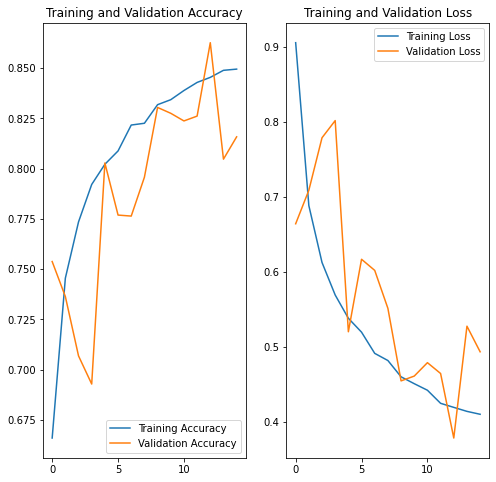

In [100]:
plotFallOffGraph(history3)

In [101]:
print(f'The highest validation accuracy obtained: {max(history3.history["val_accuracy"])}')
print(f'The lowest loss obtained: {min(history3.history["val_loss"])}')

The highest validation obtained: 0.8626000285148621
The lowest loss obtained: 0.3785991668701172


Saving Model 3

In [102]:
model3.save('./Models/Model3/')

INFO:tensorflow:Assets written to: ./Models/Model3/assets


INFO:tensorflow:Assets written to: ./Models/Model3/assets


In [103]:
tf.keras.backend.clear_session()

## Model 4 ##

In [33]:
model4.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

In [34]:
history4 = model4.fit(trainDS, epochs=15, validation_data=valDS)

Epoch 1/15
782/782 [==============================] - 80s 100ms/step - loss: 0.8655 - accuracy: 0.6895 - val_loss: 0.7637 - val_accuracy: 0.7244
Epoch 2/15
782/782 [==============================] - 78s 100ms/step - loss: 0.6030 - accuracy: 0.7807 - val_loss: 1.6984 - val_accuracy: 0.4838
Epoch 3/15
782/782 [==============================] - 78s 100ms/step - loss: 0.5157 - accuracy: 0.8109 - val_loss: 0.8643 - val_accuracy: 0.7295
Epoch 4/15
782/782 [==============================] - 80s 102ms/step - loss: 0.4748 - accuracy: 0.8290 - val_loss: 0.4997 - val_accuracy: 0.8108
Epoch 5/15
782/782 [==============================] - 74s 95ms/step - loss: 0.4618 - accuracy: 0.8329 - val_loss: 0.4708 - val_accuracy: 0.8383
Epoch 6/15
782/782 [==============================] - 82s 105ms/step - loss: 0.4197 - accuracy: 0.8484 - val_loss: 0.5549 - val_accuracy: 0.7952
Epoch 7/15
782/782 [==============================] - 80s 102ms/step - loss: 0.3992 - accuracy: 0.8552 - val_loss: 0.3995 - val_acc

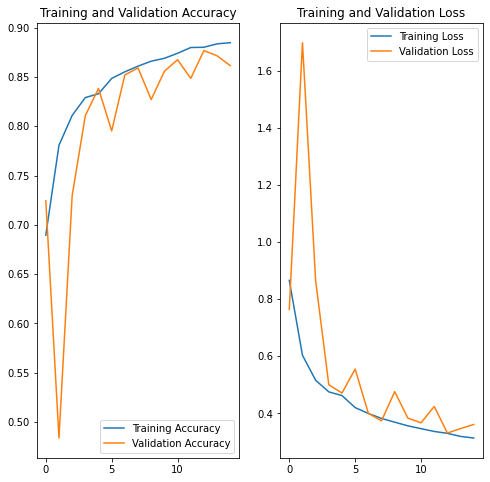

In [35]:
plotFallOffGraph(history4)

In [36]:
print(f'The highest validation accuracy obtained: {max(history4.history["val_accuracy"])}')
print(f'The lowest loss obtained: {min(history4.history["val_loss"])}')

The highest validation obtained: 0.8766999840736389
The lowest loss obtained: 0.330683171749115


Saving Model 4

In [37]:
model4.save('./Models/Model4/')

INFO:tensorflow:Assets written to: ./Models/Model4/assets


INFO:tensorflow:Assets written to: ./Models/Model4/assets


In [38]:
tf.keras.backend.clear_session()

# Candidate Models #
The Models that I will be choosing to be candidate models are Model 2 and Model 4 which will be now called Model A and Model B respectively because for both models they have the highest accuracy between all of the 4 models  
However as a way to make sure the correct model will be chosen as the final model, both candidate models will be hyperparameter tuned

This was done to ensure that both candidate models has a chance to be tested and find out which will perform better on the test set which will contain unseen data and will be the final test to choose the final model to be used

## Models Hyperparameter Training Parameters and imports ##

In [12]:
import keras_tuner as kt

## Building Models for Hyperparameter Tuning ##

In [13]:
def CandidateABuilder(hp):
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-3, 15e-4, 1e-4, 2e-3, 25e-4, 2e-4])
    hp_activation_func = hp.Choice('activation', values=['relu', 'sigmoid', 'tanh', 'swish'])

    input = layers.Input((28, 28, 1))
    x = layers.Rescaling(1/255)(input)

    x = layers.Conv2D(16, 3, padding='same', activation=hp_activation_func)(x)
    x = layers.Conv2D(32, 3, padding='same', activation=hp_activation_func)(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPool2D()(x)

    x = layers.Dense(64, activation=hp_activation_func)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(128, activation=hp_activation_func)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv2D(256, 3, padding='same', activation=hp_activation_func)(x)
    x = layers.Conv2D(128, 3, padding='same', activation=hp_activation_func)(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPool2D()(x)

    x = layers.Flatten()(x)
    x = layers.Dense(64, activation=hp_activation_func)(x)
    x = layers.BatchNormalization()(x)
    output = layers.Dense(fmnist_numClasses, activation='softmax')(x)

    model = keras.Model(inputs=input, outputs=output, name='Model_A')
    
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate), loss=keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

    return model

In [14]:
def CandidateBBuilder(hp):
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-3, 15e-4, 1e-4, 2e-3, 25e-4, 2e-4])
    hp_activation_func = hp.Choice('activation', values=['relu', 'sigmoid', 'tanh', 'swish'])

    input = layers.Input((28, 28, 1))
    x = layers.Rescaling(1/255)(input)

    x = layers.Conv2D(64, 3, padding='same', activation=hp_activation_func)(x)
    x = layers.Conv2D(32, 1, padding='same', activation=hp_activation_func)(x)
    x = layers.Conv2D(64, 3, padding='same', activation=hp_activation_func)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv2D(128, 3, padding='same', activation=hp_activation_func)(x)
    x = layers.Conv2D(64, 1, padding='same', activation=hp_activation_func)(x)
    x = layers.Conv2D(128, 3, padding='same', activation=hp_activation_func)(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPool2D()(x)

    x = layers.Dense(32, activation=hp_activation_func)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv2D(128, 3, padding='same', activation=hp_activation_func)(x)
    x = layers.Conv2D(64, 1, padding='same', activation=hp_activation_func)(x)
    x = layers.Conv2D(128, 3, padding='same', activation=hp_activation_func)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv2D(64, 3, padding='same', activation=hp_activation_func)(x)
    x = layers.Conv2D(32, 1, padding='same', activation=hp_activation_func)(x)
    x = layers.Conv2D(64, 3, padding='same', activation=hp_activation_func)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Dropout(0.2)(x)
    x = layers.Flatten()(x)
    x = layers.Dense(256, activation=hp_activation_func)(x)
    x = layers.BatchNormalization()(x)

    output = layers.Dense(fmnist_numClasses, activation='softmax')(x)

    model = keras.Model(inputs=input, outputs=output, name='Model_B')
    
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate), loss=keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

    return model

## Hyperparameter Tuning The Finalised Model ##

The tuning algorithm that I will be using is Hyperband which can be inplemented using KerasTuner
Paper that introduced Hyperband: http://jmlr.org/papers/v18/16-558.html

In [15]:
tunerA = kt.Hyperband(CandidateABuilder, objective='val_accuracy', project_name='Hypertuned_ModelA', hyperband_iterations=3, seed=42)

INFO:tensorflow:Reloading Oracle from existing project .\Hypertuned_ModelA\oracle.json
INFO:tensorflow:Reloading Tuner from .\Hypertuned_ModelA\tuner0.json


In [16]:
tunerB = kt.Hyperband(CandidateBBuilder, objective='val_accuracy', project_name='Hypertuned_ModelB', hyperband_iterations=3, seed=42)

INFO:tensorflow:Reloading Oracle from existing project .\Hypertuned_ModelB\oracle.json
INFO:tensorflow:Reloading Tuner from .\Hypertuned_ModelB\tuner0.json


### Searching for best params ###

In [17]:
tunerA.search(trainDS, epochs=100, validation_data=valDS)

best_hpsA = tunerA.get_best_hyperparameters(num_trials=1)[0]

print(f'Best learning rate: {best_hpsA.get("learning_rate")}')
print(f'Best activation function: {best_hpsA.get("activation")}')

INFO:tensorflow:Oracle triggered exit
Best learning rate: 0.0025
Best activation function: swish


In [18]:
tf.keras.backend.clear_session()

In [19]:
tunerB.search(trainDS, epochs=100, validation_data=valDS)

best_hpsB = tunerB.get_best_hyperparameters(num_trials=1)[0]

print(f'Best learning rate: {best_hpsB.get("learning_rate")}')
print(f'Best activation function: {best_hpsB.get("activation")}')

INFO:tensorflow:Oracle triggered exit
Best learning rate: 0.0002
Best activation function: swish


In [20]:
tf.keras.backend.clear_session()

### Building and Training Models with best Hyperparameters ###

#### Model A ####

<p style='text-align: center'>
    <b>Best Learning Rate using Adam Optimiser: 0.0025</b>
</p>

<img src='Images/ModelA_Arch.png' width='300' height='500' style='display:block; margin: auto'/>
<p style='text-align: center'>
    <b>Model A Architecture</b>
</p>

Setting up Model Checkpoint Callback

In [21]:
model_checkpoint_callbackA = tf.keras.callbacks.ModelCheckpoint(
    filepath='./Checkpoints/ModelA',
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True
)

Training for 100 Epochs to find the best epoch for validation accuracy

In [22]:
best_hpsA = tunerA.get_best_hyperparameters(num_trials=1)[0]

modelA = tunerA.hypermodel.build(best_hpsA)

In [23]:
historyA = modelA.fit(trainDS, epochs=100, validation_data=valDS, callbacks=[model_checkpoint_callbackA])

Epoch 1/100
782/782 [==============================] - 55s 64ms/step - loss: 0.8077 - accuracy: 0.7123 - val_loss: 1.1288 - val_accuracy: 0.6120
Epoch 2/100
782/782 [==============================] - 38s 49ms/step - loss: 0.5711 - accuracy: 0.7947 - val_loss: 0.7349 - val_accuracy: 0.7327
Epoch 3/100
782/782 [==============================] - 39s 50ms/step - loss: 0.5067 - accuracy: 0.8179 - val_loss: 0.5483 - val_accuracy: 0.8030
Epoch 4/100
782/782 [==============================] - 40s 51ms/step - loss: 0.4665 - accuracy: 0.8310 - val_loss: 0.5504 - val_accuracy: 0.7967
Epoch 5/100
782/782 [==============================] - 38s 49ms/step - loss: 0.4346 - accuracy: 0.8430 - val_loss: 0.5606 - val_accuracy: 0.7921
Epoch 6/100
782/782 [==============================] - 39s 50ms/step - loss: 0.4153 - accuracy: 0.8506 - val_loss: 0.4342 - val_accuracy: 0.8433
Epoch 7/100
782/782 [==============================] - 39s 50ms/step - loss: 0.3994 - accuracy: 0.8564 - val_loss: 0.5057 - val_ac

Plotting Accuracy and Loss for 100 Epochs

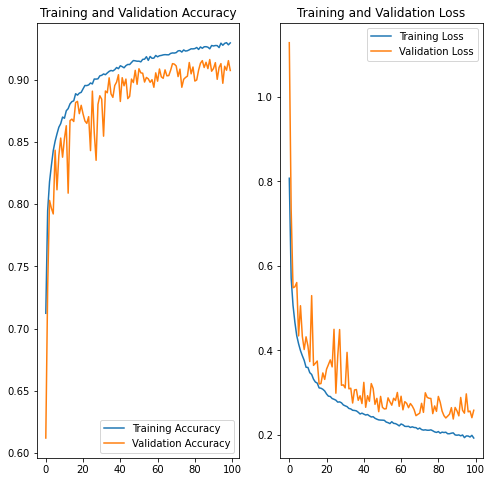

In [24]:
plotFallOffGraph(historyA)

Model A's Best Epoch

In [25]:
val_acc_per_epochA = historyA.history['val_accuracy']
best_epochA = val_acc_per_epochA.index(max(val_acc_per_epochA)) + 1
print(f'Best Epoch: {best_epochA}')

Best Epoch: 89


Model A's Train and Validation Accuracies

In [26]:
print(f'Training Accuracy: {max(historyA.history["accuracy"])}')
print(f'Validation Accuracy: {max(historyA.history["val_accuracy"])}')

Training Accuracy: 0.9297400116920471
Validation Accuracy: 0.9161999821662903


Model A's Train and Validation Losses

In [27]:
print(f'Training Loss: {min(historyA.history["loss"])}')
print(f'Validation Loss: {min(historyA.history["val_loss"])}')

Training Loss: 0.19222979247570038
Validation Loss: 0.2372763603925705


Saving Model A

In [28]:
modelA.load_weights('./Checkpoints/ModelA')

In [29]:
modelA.save('./Models/ModelA')

INFO:tensorflow:Assets written to: ./Models/ModelA\assets


INFO:tensorflow:Assets written to: ./Models/ModelA\assets


Clearing Session

In [30]:
tf.keras.backend.clear_session()

#### Model B ####

<p style='text-align: center'>
    <b>Best Learning Rate using Adam Optimiser: 0.0002</b>
</p>

<img src='Images/ModelB_Arch.png' width='300' height='500' style='display:block; margin: auto'/>
<p style='text-align: center'>
    <b>Model B Architecture</b>
</p>

Setting up Model Checkpoint Callback

In [31]:
model_checkpoint_callbackB = tf.keras.callbacks.ModelCheckpoint(
    filepath='./Checkpoints/ModelB',
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True
)

In [32]:
best_hpsB = tunerB.get_best_hyperparameters(num_trials=1)[0]

modelB = tunerB.hypermodel.build(best_hpsB)

In [33]:
historyB = modelB.fit(trainDS, epochs=100, validation_data=valDS, callbacks=[model_checkpoint_callbackB])

Epoch 1/100
782/782 [==============================] - 53s 65ms/step - loss: 0.8457 - accuracy: 0.6993 - val_loss: 0.8208 - val_accuracy: 0.7115
Epoch 2/100
782/782 [==============================] - 50s 64ms/step - loss: 0.5857 - accuracy: 0.7884 - val_loss: 0.5795 - val_accuracy: 0.7882
Epoch 3/100
782/782 [==============================] - 50s 64ms/step - loss: 0.5102 - accuracy: 0.8155 - val_loss: 0.6472 - val_accuracy: 0.7633
Epoch 4/100
782/782 [==============================] - 50s 64ms/step - loss: 0.4636 - accuracy: 0.8310 - val_loss: 0.5132 - val_accuracy: 0.8094
Epoch 5/100
782/782 [==============================] - 50s 64ms/step - loss: 0.4305 - accuracy: 0.8442 - val_loss: 0.3930 - val_accuracy: 0.8569
Epoch 6/100
782/782 [==============================] - 50s 63ms/step - loss: 0.4011 - accuracy: 0.8537 - val_loss: 0.4186 - val_accuracy: 0.8479
Epoch 7/100
782/782 [==============================] - 49s 63ms/step - loss: 0.3833 - accuracy: 0.8611 - val_loss: 0.4530 - val_ac

Plotting Accuracy and Loss

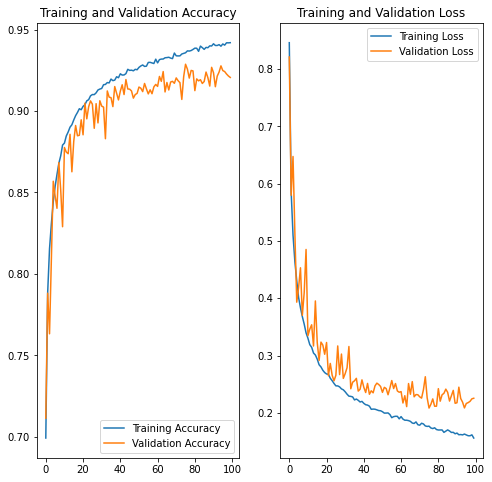

In [34]:
plotFallOffGraph(historyB)

Model B's Best Epoch

In [35]:
val_acc_per_epochB = historyB.history['val_accuracy']
best_epochB = val_acc_per_epochB.index(max(val_acc_per_epochB)) + 1
print(f'Best Epoch: {best_epochB}')

Best Epoch: 76


Model B's Train and Validation Accuracies

In [36]:
print(f'Training Accuracy: {max(historyB.history["accuracy"])}')
print(f'Validation Accuracy: {max(historyB.history["val_accuracy"])}')

Training Accuracy: 0.9419199824333191
Validation Accuracy: 0.9286999702453613


Model B's Train and Validation Losses

In [37]:
print(f'Training Loss: {min(historyB.history["loss"])}')
print(f'Validation Loss: {min(historyB.history["val_loss"])}')

Training Loss: 0.15604497492313385
Validation Loss: 0.20832790434360504


Saving Model B

In [38]:
modelB.load_weights('./Checkpoints/ModelB')

In [39]:
modelB.save('./Models/ModelB')

INFO:tensorflow:Assets written to: ./Models/ModelB\assets


INFO:tensorflow:Assets written to: ./Models/ModelB\assets


Clearing Session

In [40]:
tf.keras.backend.clear_session()

# Testing Candidate Models #
Loading and Evaluating Models

In [41]:
modelA = tf.keras.models.load_model('./Models/ModelA/')

evalA = modelA.evaluate(testDS)

print(f'Loss for ModelA: {evalA[0]}')
print(f'Accuracy for ModelA: {evalA[1]}')

157/157 [==============================] - 2s 10ms/step - loss: 0.2533 - accuracy: 0.9093
Loss for ModelA: 0.25331681966781616
Accuracy for ModelA: 0.9093000292778015


In [42]:
modelB = tf.keras.models.load_model('./Models/ModelB/')

evalB = modelB.evaluate(testDS)

print(f'Loss for ModelB: {evalB[0]}')
print(f'Accuracy for ModelB: {evalB[1]}')

157/157 [==============================] - 3s 15ms/step - loss: 0.2220 - accuracy: 0.9228
Loss for ModelB: 0.22200249135494232
Accuracy for ModelB: 0.9228000044822693


# The Final Model #
The final model from the candidate models will be Model B as on the final evaluation as it performs the best in terms of both accuracy and loss and the learning curves for the training set and validation set are also less volatile as compared to Model A and it is closer to each other  
Now I will move on to model understanding and see how does the model determines its outputs from images

<img src='Images/ModelB_Arch.png' width='300' height='500' style='display:block; margin: auto'/>
<p style='text-align: center'>
    <b>Model B Architecture</b>
</p>

Loading the Model

In [43]:
modelB = tf.keras.models.load_model('./Models/ModelB/')

# Model Understanding #

## Implementing Integrated Gradients ##
Uses  
-   Helps develop intuition for how and why it works
-   If features highlighted does not match intuition, it may mean that there is a bug in the model or dataset or may be indicative of overfitting

Limitations  
-   Only provides feature importance on individual examples and therefore does not provide global feature importance across datasets  
-   Only provides individual feature importance and therefore does not explain feature interactions and combinations

### Establishing a baseline image ###

Just going to be a black 28 * 28 * 1 image for now so that it will be the same as the input image

In [44]:
baseline = tf.zeros(shape=(28, 28, 1))

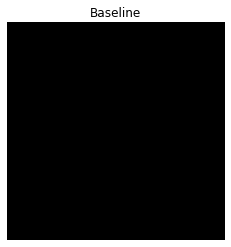

In [45]:
plt.imshow(baseline, cmap='gray')
plt.title("Baseline")
plt.axis('off')
plt.show()

### Interpolate Images ###

In [46]:
def interpolate_images(baseline, image, alphas):
  alphas_x = alphas[:, tf.newaxis, tf.newaxis, tf.newaxis]
  baseline_x = tf.expand_dims(baseline, axis=0)
  input_x = tf.expand_dims(image, axis=0)
  delta = input_x - baseline_x
  images = baseline_x +  alphas_x * delta
  
  return images

### Compute Gradients ###

In [47]:
def compute_gradients(images, target_class_idx):
  with tf.GradientTape() as tape:
    tape.watch(images)
    probs = modelB(images)
    
  return tape.gradient(probs, images)

### Integral Approximation ###

In [48]:
def integral_approximation(gradients):
  # riemann_trapezoidal
  grads = (gradients[:-1] + gradients[1:]) / tf.constant(2.0)
  integrated_gradients = tf.math.reduce_mean(grads, axis=0)
  
  return integrated_gradients

### Putting it all together ###

Combines the 3 previous parts together into a function called Integrated Gradients and will use a @tf.function decorator to compile it into a high performance TensorFlow graph  

$$
IntegratedGrads^{approx}_{i}(x)::=\overbrace{(x_{i}-x'_{i})}^\text{5.}\times \overbrace{\sum_{k=1}^{m} }^\text{4.} \frac{\partial \overbrace{F(\overbrace{x' + \overbrace{\frac{k}{m} }^\text{1.}\times(x - x'))}^\text{2.} }^\text{3.} }{\partial x_{i} } \times \overbrace{\frac{1}{m} }^\text{4.}
$$

#### Steps ####
1. Generate alphas
2. Generate interpolated images = $(x' + \frac{k}{m}\times(x - x'))$
3. Compute gradients between model $F$ output predictions with respect to input features = $\frac{\partial F(\text{interpolated path inputs})}{\partial x_{i} }$
4. Integral approximation through averaging gradients = $\sum_{k=1}^m \text{gradients} \times \frac{1}{m}$
5. Scale integrated gradients with respect to original image = $(x_{i}-x'_{i}) \times \text{integrated gradients}$. The reason this step is necessary is to make sure that the attribution values accumulated across multiple interpolated images are in the same units and faithfully represent the pixel importances on the original image.

In [50]:
@tf.function
def one_batch(baseline, image, alpha_batch, target_class_idx):
    # Generate interpolated inputs between baseline and input.
    interpolated_path_input_batch = interpolate_images(baseline=baseline, image=image, alphas=alpha_batch)

    # Compute gradients between model outputs and interpolated inputs.
    gradient_batch = compute_gradients(images=interpolated_path_input_batch, target_class_idx=target_class_idx)
    
    return gradient_batch

In [51]:
def integrated_gradients(baseline, image, target_class_idx, m_steps=50, batch_size=32):
  # Generate alphas.
  alphas = tf.linspace(start=0.0, stop=1.0, num=m_steps+1)

  # Collect gradients.    
  gradient_batches = []

  # Iterate alphas range and batch computation for speed, memory efficiency, and scaling to larger m_steps.
  for alpha in tf.range(0, len(alphas), batch_size):
    from_ = alpha
    to = tf.minimum(from_ + batch_size, len(alphas))
    alpha_batch = alphas[from_:to]

    gradient_batch = one_batch(baseline, image, alpha_batch, target_class_idx)
    gradient_batches.append(gradient_batch)

  # Concatenate path gradients together row-wise into single tensor.
  total_gradients = tf.concat(gradient_batches, axis=0)

  # Integral approximation through averaging gradients.
  avg_gradients = integral_approximation(gradients=total_gradients)

  # Scale integrated gradients with respect to input.
  integrated_gradients = (image - baseline) * avg_gradients

  return integrated_gradients

In [52]:
def plot_img_attributions(baseline, image, target_class_idx, m_steps=50, cmap=None, overlay_alpha=0.4):

  attributions = integrated_gradients(baseline=baseline, image=image, target_class_idx=target_class_idx, m_steps=m_steps)

  # Sum of the attributions across color channels for visualization.
  # The attribution mask shape is a grayscale image with height and width
  # equal to the original image.
  attribution_mask = tf.reduce_sum(tf.math.abs(attributions), axis=-1)

  fig, axs = plt.subplots(nrows=2, ncols=2, squeeze=False, figsize=(8, 8))

  axs[0, 0].set_title('Baseline image')
  axs[0, 0].imshow(baseline, cmap=cmap)
  axs[0, 0].axis('off')

  axs[0, 1].set_title('Original image')
  axs[0, 1].imshow(image, cmap=cmap)
  axs[0, 1].axis('off')

  axs[1, 0].set_title('Attribution mask')
  axs[1, 0].imshow(attribution_mask, cmap=cmap)
  axs[1, 0].axis('off')

  axs[1, 1].set_title('Overlay')
  axs[1, 1].imshow(attribution_mask, cmap=cmap)
  axs[1, 1].imshow(image, alpha=overlay_alpha)
  axs[1, 1].axis('off')

  plt.tight_layout()
  
  return fig

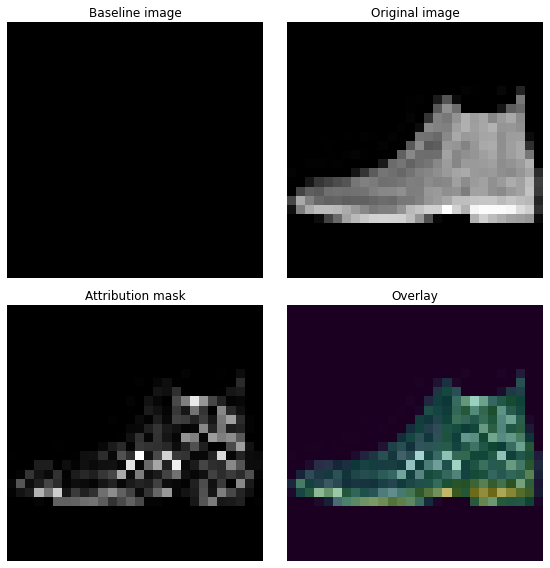

In [53]:
_ = plot_img_attributions(image=np.expand_dims(X_test[0], 2).astype('float32'), baseline=baseline, target_class_idx=y_test[0], m_steps=240, cmap='gray', overlay_alpha=0.4)

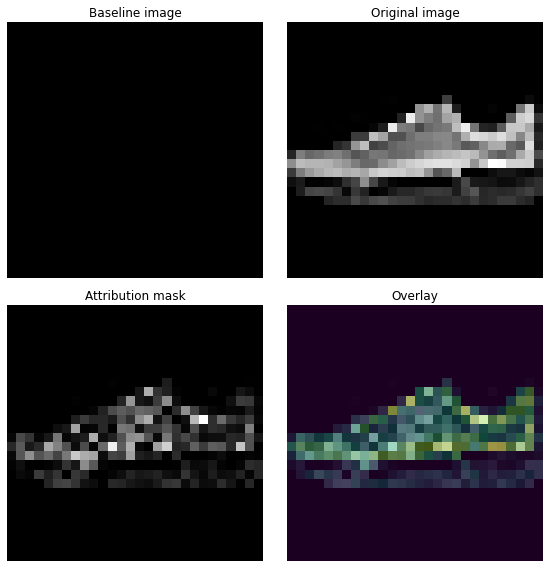

In [54]:
_ = plot_img_attributions(image=np.expand_dims(X_test[9], 2).astype('float32'), baseline=baseline, target_class_idx=y_test[9], m_steps=240, cmap='gray', overlay_alpha=0.4)

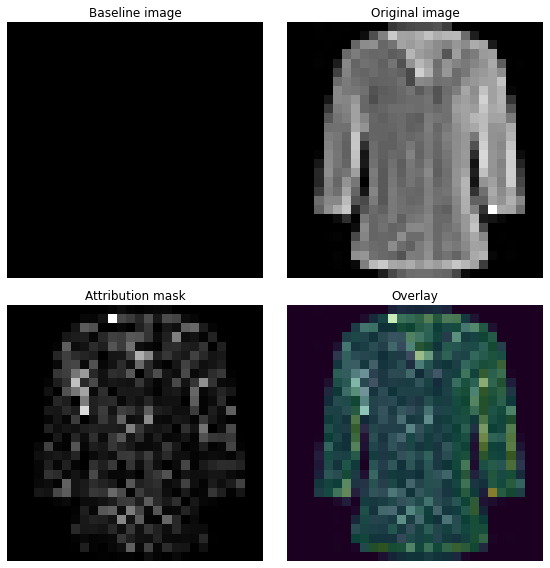

In [55]:
_ = plot_img_attributions(image=np.expand_dims(X_test[4], 2).astype('float32'), baseline=baseline, target_class_idx=y_test[4], m_steps=240, cmap='gray', overlay_alpha=0.4)

By using integrated gradients, it can be seen that the model has a reason why and how it predicts its outputs, which is the outline of the clothing item